In [1]:
# %load tfim1d.py
"""
Test Lindblad based method for ground state preparation for TFIM.

"""

from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spinful_fermion_basis_1d

import numpy as np # generic math functions
import scipy.linalg as la
import matplotlib.pyplot as plt
from numpy import linalg as la
from qutip import Qobj, mesolve

from lindblad import Lindblad


if __name__ == "__main__":
    ###### define model parameters ######
    L = 4  # number of sites for spin 1
    #
    J = 1.0  # hopping matrix element
    U = 2.0  # onsite interaction
    mu = 0.5  # chemical potential
    #
    basis = spinful_fermion_basis_1d(L)
    #
    ###### setting up hamiltonian ######
    # setting up site-coupling lists
    hopping_left = [[-J, i, i+1] for i in range(L-1)]
    hopping_right = [[+J, i, i+1] for i in range(L-1)]
    potential = [[-mu, i] for i in range(L)]
    interaction = [[U, i, i+1] for i in range(L-1)]
    #
    static = [
        ["+-|", hopping_left],
        ["|+-", hopping_left],
        ["-+|", hopping_right],
        ["|-+", hopping_right],
        ["n|", potential],
        ["|n", potential],
        ["n|n", interaction],
    ]
    # build hamiltonian
    H = hamiltonian(static, [], basis=basis, dtype=np.float64)
    #dynamic terms are empty
    dynamic = []
    #Construct Hamiltonian
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    H = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)
    #Find ground state
    E_GS,psi_GS = H.eigsh(k=1,which="SA")
    psi_GS = psi_GS.flatten()
    #Transform from sparse matrix to dense matrix
    H_mat = np.array(H.todense())
    #define intereacting A
    gamma=0.1
    K_A=4
    annihilation=np.sqrt(gamma)*np.array([[0,1,0,0],[0,0,0,0],[0,0,0,1],[0,0,0,0]])
    A_mat=np.zeros((4**L,4**L,K_A),dtype=complex)
    A_mat[:,:,0]=np.kron(annihilation,np.identity(64))
    A_mat[:,:,1]=np.kron(np.kron(np.identity(4),annihilation),np.identity(16))
    A_mat[:,:,2]=np.kron(np.kron(np.identity(16),annihilation),np.identity(4))
    A_mat[:,:,3]=np.kron(np.identity(64),annihilation)


    lb = Lindblad(H_mat,A_mat)

    
    psi0 = psi_GS
    #print('psi0',psi0)  
    
    T = 1
    K = 7
    num_t_1=np.zeros(K)
    rho_error_first=np.zeros(K)
    rho_error_second=np.zeros(K)
    rho_error_third=np.zeros(K)
    result = lb.Lindblad_exact(T, (2**(1+K)), psi0)
    print('result finished')
    for n in range(K):
        num_t_1[n] = T*(2**(1+n))
        print('num_t_1[n]',num_t_1[n])
        num_t=int(num_t_1[n])
        times = np.arange(num_t+1) * (T/num_t)
        rho_first=lb.Lindblad_H(T, num_t, psi0,1)
        rho_second=lb.Lindblad_H(T, num_t, psi0,2)
        rho_third=lb.Lindblad_H(T, num_t, psi0,3)
        rho_error_first[n]=la.norm(result[:,:,len(result[0,0,:])-1]-rho_first[:,:,int(num_t)], 'nuc')
        rho_error_second[n]=la.norm(result[:,:,len(result[0,0,:])-1]-rho_second[:,:,int(num_t)], 'nuc')
        rho_error_third[n]=la.norm(result[:,:,len(result[0,0,:])-1]-rho_third[:,:,int(num_t)], 'nuc')

Hermiticity check passed!
Symmetry checks passed!
result finished
num_t_1[n] 2.0
H_0-H^\dag_0= 0.0


MemoryError: Unable to allocate 38.7 GiB for an array with shape (5, 22784, 22784) and data type complex128

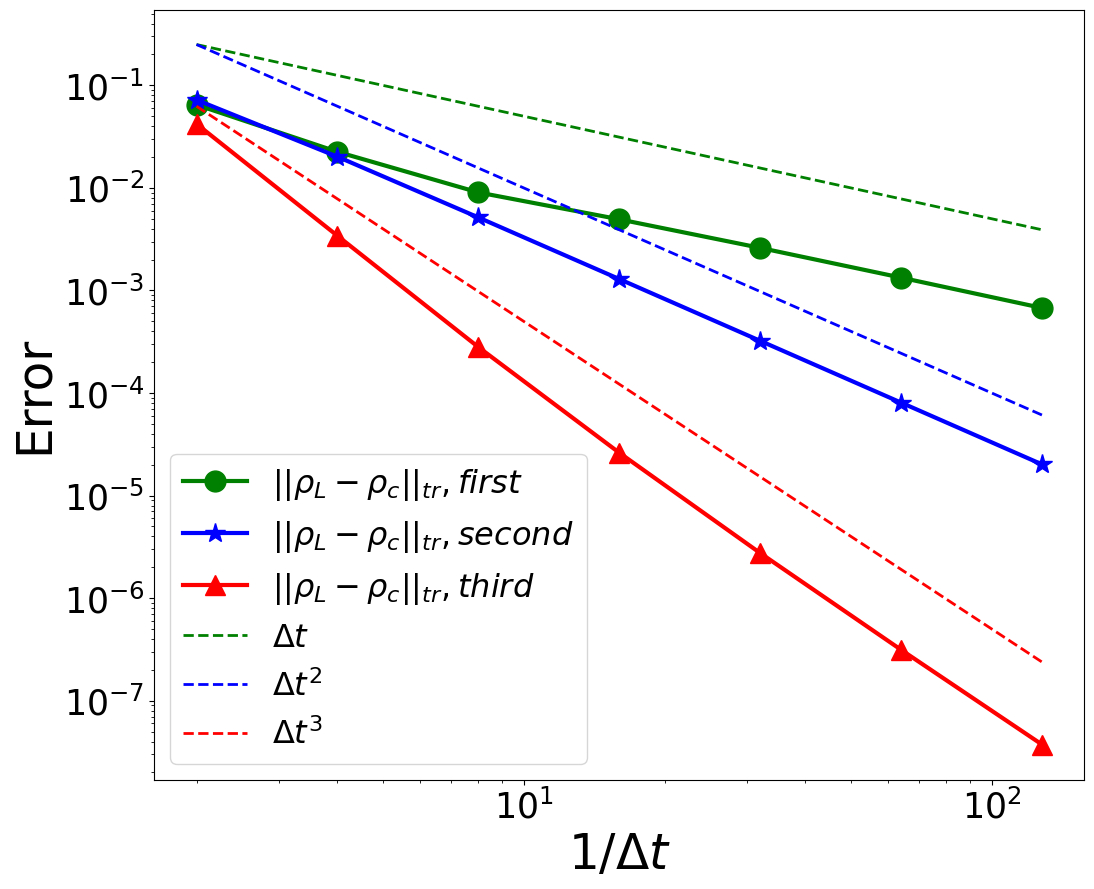

In [4]:
# Error checking (Exact vs coherent)
plt.figure(figsize=(12,10))
plt.plot(num_t_1/T, np.abs(rho_error_first), 'g-o', label=r'$||\rho_L-\rho_c||_{tr},first$', linewidth=3,markersize=15)
plt.plot(num_t_1/T, np.abs(rho_error_second), 'b-*', label=r'$||\rho_L-\rho_c||_{tr},second$', linewidth=3,markersize=15)
plt.plot(num_t_1/T, np.abs(rho_error_third), 'r-^', label=r'$||\rho_L-\rho_c||_{tr},third$', linewidth=3,markersize=15)
# plt.plot(num_t_1/T, np.abs(rho_error_SDE), 'y-o', label=r'$||\rho_L-\rho_c||_{tr},SDE$', linewidth=3,markersize=10)
plt.plot(num_t_1/T, 0.5/(num_t_1), 'g--', label=r'$\Delta t$', linewidth=2)
plt.plot(num_t_1/T, 1/(num_t_1)**2, 'b--', label=r'$\Delta t^{2}$', linewidth=2)
plt.plot(num_t_1/T, 0.5/(num_t_1)**3, 'r--', label=r'$\Delta t^{3}$', linewidth=2)
plt.legend()
plt.xlabel(r'$1/\Delta t$',fontsize=35)
plt.ylabel('Error',fontsize=35)
plt.yscale("log")
plt.xscale("log")
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=23)
plt.savefig('Error_compare_Hubbard_1D.pdf')
plt.show()

In [11]:
#check overlap
#lb = Lindblad(H_mat,A_mat)
# fix the random seed
vt = np.random.randn(lb.Ns)+1j*np.random.randn(lb.Ns)
psi0 = psi_GS
# arbitrary initial condition
#     psi0 = vt.copy()
#     psi0 = psi0 / la.norm(psi0)
T = 5
num_t=25
overlap_exact=np.zeros(num_t)
overlap_first=np.zeros(num_t)
overlap_second=np.zeros(num_t)
overlap_third=np.zeros(num_t)
result = lb.Lindblad_exact(T, num_t, psi0)
times = np.arange(num_t) * (T/num_t)
rho_first=lb.Lindblad_H(T, num_t, psi0,1)
rho_second=lb.Lindblad_H(T, num_t, psi0,2)
rho_third=lb.Lindblad_H(T, num_t, psi0,3)
for n in range(num_t):
    overlap_first[n]=psi0.conj()@rho_first[:,:,n]@ psi0
    overlap_second[n]=psi0.conj()@rho_second[:,:,n]@ psi0
    overlap_third[n]=psi0.conj()@rho_third[:,:,n]@ psi0

H_0-H^\dag_0= 0.0
H_0-H^\dag_0= 1.0123497716863163e-16
H_0-H^\dag_0= 1.0592442528056837e-16


C:\Users\b5172\AppData\Local\Temp\ipykernel_32396\3367417818.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  overlap_first[n]=psi0.conj()@rho_first[:,:,n]@ psi0
C:\Users\b5172\AppData\Local\Temp\ipykernel_32396\3367417818.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  overlap_second[n]=psi0.conj()@rho_second[:,:,n]@ psi0
C:\Users\b5172\AppData\Local\Temp\ipykernel_32396\3367417818.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  overlap_third[n]=psi0.conj()@rho_third[:,:,n]@ psi0


C:\Users\b5172\AppData\Local\Temp\ipykernel_32396\1574645671.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  overlap_exact[n]=psi0.conj()@result[:,:,10*n]@ psi0


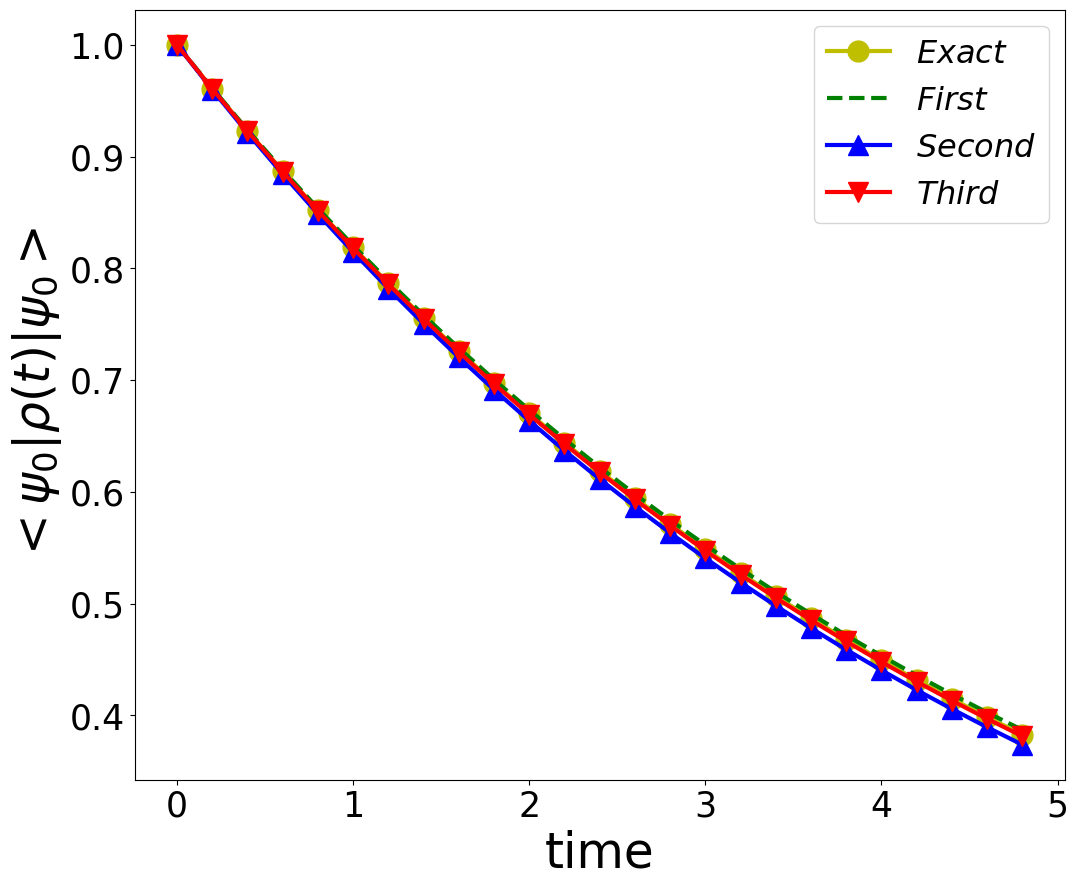

In [13]:
for n in range(num_t):
    overlap_exact[n]=psi0.conj()@result[:,:,10*n]@ psi0
# Error checking (Exact vs coherent)
times = np.arange(num_t) * (T/num_t)
plt.figure(figsize=(12,10))
plt.plot(times, np.abs(overlap_exact), 'y-o', label=r'$Exact$', linewidth=3,markersize=15)
plt.plot(times, np.abs(overlap_first), 'g--', label=r'$First$', linewidth=3,markersize=15)
plt.plot(times, np.abs(overlap_second), 'b-^', label=r'$Second$', linewidth=3,markersize=15)
plt.plot(times, np.abs(overlap_third), 'r-v', label=r'$Third$', linewidth=3,markersize=15)
plt.legend()
plt.xlabel(r'time',fontsize=35)
plt.ylabel(r'$<\psi_0|\rho(t)|\psi_0>$',fontsize=35)
# plt.yscale("log")
# plt.xscale("log")
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=23)
plt.savefig('Overlap_compare_Number_T=5.pdf')
plt.show()